In [1]:
!pip install -q geemap geopandas earthengine-api rasterio shapely matplotlib plotly pandas scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import ee
import geemap
import geopandas as gpd
import rasterio
import shapely
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm

def mount_drive():
    """
    Mounts Google Drive to /content/drive for file access.
    """
    drive.mount('/content/drive')
    print("Google Drive mounted at /content/drive.")

mount_drive()

Mounted at /content/drive
Google Drive mounted at /content/drive.


In [3]:
def authenticate_and_initialize_ee(project_id: str):
    """
    Authenticates the user and initializes the Earth Engine API using the specified Google Cloud project.
    """
    ee.Authenticate()
    ee.Initialize(project=project_id)
    print(f"Earth Engine initialized with project: {project_id}")

# Use your saved project_id
authenticate_and_initialize_ee('mohamed-elsayed1998')

Earth Engine initialized with project: mohamed-elsayed1998


In [4]:
def load_roi_from_geojson(geojson_path: str):
    """
    Loads a GeoJSON file as a GeoDataFrame and converts it to an Earth Engine FeatureCollection.
    """
    gdf = gpd.read_file(geojson_path)
    geojson_dict = gdf.to_json()
    roi = ee.FeatureCollection(json.loads(geojson_dict))
    print("ROI loaded and converted to Earth Engine FeatureCollection.")
    return roi

import json

# Update the path if your GeoJSON is in a different location
geojson_path = '/content/drive/MyDrive/GEE Datasets/Blue_Mountains.json'

roi = load_roi_from_geojson(geojson_path)

ROI loaded and converted to Earth Engine FeatureCollection.


In [5]:
def get_modis_burned_area(roi, start_date: str, end_date: str):
    """
    Loads MODIS MCD64A1 burned area product, filters by date and ROI,
    and returns a FeatureCollection of burned polygons.
    """
    burned = (
        ee.ImageCollection('MODIS/006/MCD64A1')
        .filterDate(start_date, end_date)
        .select('BurnDate')
        .map(lambda img: img.gt(0))
        .max()
        .selfMask()
    )

    vectors = burned.reduceToVectors(
        geometry=roi,
        scale=500,
        geometryType='polygon',
        labelProperty='burned',
        eightConnected=True,
        maxPixels=1e13
    )
    print("MODIS burned-area polygons extracted.")
    return vectors

# Burn period: Black Summer (Jul-2019 → Jun-2020)
burn_fc = get_modis_burned_area(
    roi=roi,
    start_date='2019-07-01',
    end_date='2020-06-30'
)

MODIS burned-area polygons extracted.


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MCD64A1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD64A1

  warnings.warn(warning, category=DeprecationWarning)


In [6]:
def get_landsat8_nbr_collection(
    roi,
    start_date: str,
    end_date: str,
    cloud_pct: float = 20.0
):
    """
    Loads Landsat 8 SR images for the ROI and date range, filters by cloud cover,
    and adds an NBR band to each image.
    """
    col = (
        ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
        .filterBounds(roi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUD_COVER', cloud_pct))
        .map(lambda img: img.addBands(
            img.normalizedDifference(['SR_B5', 'SR_B7']).rename('NBR')
        ))
    )
    print(f"Landsat 8 NBR collection loaded: {col.size().getInfo()} images")
    return col

ls8_nbr_col = get_landsat8_nbr_collection(
    roi=roi,
    start_date='2019-07-01',
    end_date='2020-06-30',
    cloud_pct=20.0
)

Landsat 8 NBR collection loaded: 42 images


In [7]:
def compute_nbr_composites(
    ls8_nbr_col,
    roi,
    pre_range: tuple,
    post_range: tuple
):
    """
    Computes median NBR composites for pre-fire and post-fire periods, then calculates dNBR.
    Returns pre_nbr, post_nbr, dnbr images (all clipped to ROI).
    """
    pre_nbr = (
        ls8_nbr_col
        .filterDate(*pre_range)
        .select('NBR')
        .median()
        .clip(roi)
    )
    post_nbr = (
        ls8_nbr_col
        .filterDate(*post_range)
        .select('NBR')
        .median()
        .clip(roi)
    )
    dnbr = pre_nbr.subtract(post_nbr).rename('dNBR')
    print("Computed pre-fire NBR, post-fire NBR, and dNBR composites.")
    return pre_nbr, post_nbr, dnbr

# Define actual Black Summer fire periods
pre_range = ('2019-07-01', '2019-11-01')
post_range = ('2020-02-01', '2020-06-30')

pre_nbr, post_nbr, dnbr = compute_nbr_composites(
    ls8_nbr_col=ls8_nbr_col,
    roi=roi,
    pre_range=pre_range,
    post_range=post_range
)

Computed pre-fire NBR, post-fire NBR, and dNBR composites.


In [8]:
def plot_nbr_dnbr_layers(roi, pre_nbr, post_nbr, dnbr):
    """
    Displays pre-fire NBR, post-fire NBR, and dNBR layers on an interactive map.
    """
    m = geemap.Map(center=[-33.6, 150.3], zoom=10)

    pre_nbr_vis = {'min': 0, 'max': 1, 'palette': ['white', 'green']}
    post_nbr_vis = {'min': 0, 'max': 1, 'palette': ['white', 'green']}
    dnbr_vis = {
        'min': 0, 'max': 0.7,
        'palette': ['white', 'yellow', 'orange', 'red', 'black']
    }

    m.addLayer(pre_nbr, pre_nbr_vis, 'Pre-fire NBR')
    m.addLayer(post_nbr, post_nbr_vis, 'Post-fire NBR')
    m.addLayer(dnbr, dnbr_vis, 'dNBR')
    m.addLayer(roi, {'color': 'blue'}, 'ROI', False)
    m.addLayerControl()
    return m

# Show map
plot_nbr_dnbr_layers(roi, pre_nbr, post_nbr, dnbr)

Map(center=[-33.6, 150.3], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [9]:
def classify_burn_severity(dnbr):
    """
    Classifies dNBR according to USGS burn severity thresholds.
    Returns a classified image with integer burn severity codes.
    """
    classes = [
        (0.1, 0),       # Unburned/Low
        (0.27, 1),      # Low
        (0.44, 2),      # Moderate
        (0.66, 3),      # High
        (1.0, 4)        # Extreme
    ]
    severity = ee.Image(0).rename('severity')
    for threshold, code in classes:
        severity = severity.where(dnbr.gt(threshold), code)
    severity = severity.updateMask(dnbr.mask()).toInt8()
    print("dNBR classified into burn severity classes.")
    return severity

burn_severity = classify_burn_severity(dnbr)

dNBR classified into burn severity classes.


In [10]:
def export_to_drive(image, roi, description, file_name, scale=30):
    """
    Exports an Earth Engine image to Google Drive as GeoTIFF.
    """
    task = ee.batch.Export.image.toDrive(
        image=image.clip(roi),
        description=description,
        folder='GEE_exports',
        fileNamePrefix=file_name,
        region=roi.geometry().bounds().getInfo()['coordinates'],
        scale=scale,
        maxPixels=1e13,
        fileFormat='GeoTIFF'
    )
    task.start()
    print(f"Export task '{description}' started (check Google Drive > GEE_exports).")

# Export dNBR map
export_to_drive(dnbr, roi, 'dNBR_export', 'blue_mountains_dNBR', scale=30)

# Export burn severity classes
export_to_drive(burn_severity, roi, 'burn_severity_export', 'blue_mountains_severity', scale=30)

Export task 'dNBR_export' started (check Google Drive > GEE_exports).
Export task 'burn_severity_export' started (check Google Drive > GEE_exports).


In [11]:
def sample_image_to_csv(image, roi, properties, n_samples, scale, csv_name):
    """
    Samples pixels from an image within ROI and exports as CSV to Google Drive.
    """
    samples = image.sample(
        region=roi,
        scale=scale,
        numPixels=n_samples,
        seed=42,
        geometries=True
    ).select(properties)

    task = ee.batch.Export.table.toDrive(
        collection=samples,
        description=f'export_{csv_name}',
        folder='GEE_exports',
        fileNamePrefix=csv_name,
        fileFormat='CSV'
    )
    task.start()
    print(f"CSV export task for '{csv_name}' started.")

# Example: sample dNBR and severity values for ML/statistics
sample_image = dnbr.addBands(burn_severity)
properties = ['dNBR', 'severity']
sample_image_to_csv(
    image=sample_image,
    roi=roi,
    properties=properties,
    n_samples=2000,
    scale=30,
    csv_name='bm_dnbr_severity_samples'
)

CSV export task for 'bm_dnbr_severity_samples' started.


CSV loaded. Sample:
   system:index      dNBR  severity  \
0             0  0.099410         0   
1             1  0.038286         0   
2             2  0.068770         0   
3             3  0.305584         1   
4             4  0.036111         0   

                                                .geo  
0  {"type":"Point","coordinates":[150.36731248494...  
1  {"type":"Point","coordinates":[150.39053541615...  
2  {"type":"Point","coordinates":[150.21071255602...  
3  {"type":"Point","coordinates":[150.33669142082...  
4  {"type":"Point","coordinates":[150.51014523708...  

Descriptive statistics:
       system:index         dNBR     severity
count   2000.000000  2000.000000  2000.000000
mean     999.500000     0.076256     0.066500
std      577.494589     0.102963     0.249216
min        0.000000    -0.228120     0.000000
25%      499.750000     0.008791     0.000000
50%      999.500000     0.041555     0.000000
75%     1499.250000     0.132778     0.000000
max     1999.000000   

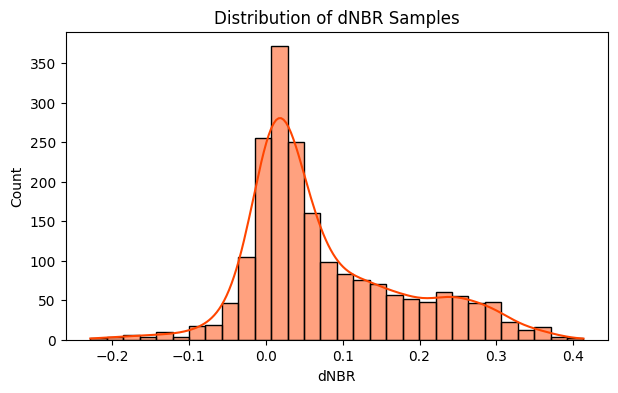

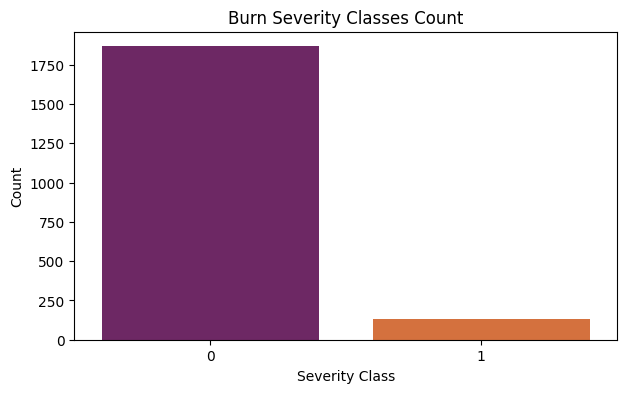

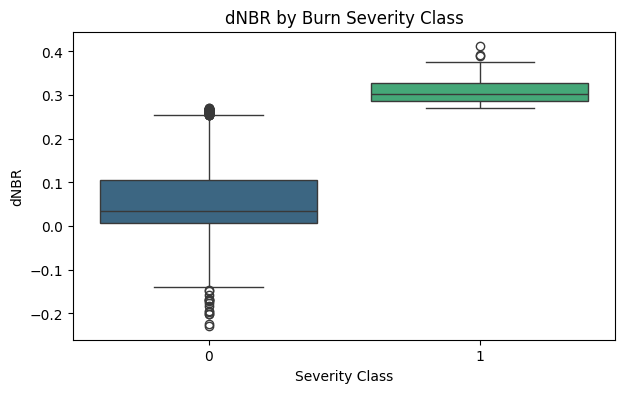

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_analyze_csv(csv_path):
    df = pd.read_csv(csv_path)
    print("CSV loaded. Sample:")
    print(df.head())

    print("\nDescriptive statistics:")
    print(df.describe())

    plt.figure(figsize=(7,4))
    sns.histplot(df['dNBR'], bins=30, kde=True, color='orangered')
    plt.title('Distribution of dNBR Samples')
    plt.xlabel('dNBR')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(7,4))
    sns.countplot(x='severity', data=df, palette='inferno')
    plt.title('Burn Severity Classes Count')
    plt.xlabel('Severity Class')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(7,4))
    sns.boxplot(x='severity', y='dNBR', data=df, palette='viridis')
    plt.title('dNBR by Burn Severity Class')
    plt.xlabel('Severity Class')
    plt.ylabel('dNBR')
    plt.show()

csv_path = '/content/drive/MyDrive/GEE Datasets/GEE_Exports/bm_dnbr_severity_samples.csv'
load_and_analyze_csv(csv_path)

In [14]:
import os

def save_analysis_outputs(csv_path, output_folder):
    """
    Loads CSV, saves all plots (PNG) and statistics (TXT) into an output folder on Google Drive.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    df = pd.read_csv(csv_path)

    # Save head/sample
    df.head().to_csv(os.path.join(output_folder, 'bm_samples_head.csv'), index=False)

    # Save descriptive statistics
    stats = df.describe()
    stats.to_csv(os.path.join(output_folder, 'bm_descriptive_stats.csv'))
    with open(os.path.join(output_folder, 'bm_descriptive_stats.txt'), 'w') as f:
        f.write(str(stats))

    # Plot and save dNBR histogram
    plt.figure(figsize=(7,4))
    sns.histplot(df['dNBR'], bins=30, kde=True, color='orangered')
    plt.title('Distribution of dNBR Samples')
    plt.xlabel('dNBR')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'dnbr_hist.png'))
    plt.close()

    # Plot and save severity class counts
    plt.figure(figsize=(7,4))
    sns.countplot(x='severity', data=df, palette='inferno')
    plt.title('Burn Severity Classes Count')
    plt.xlabel('Severity Class')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'severity_class_count.png'))
    plt.close()

    # Plot and save boxplot dNBR by severity
    plt.figure(figsize=(7,4))
    sns.boxplot(x='severity', y='dNBR', data=df, palette='viridis')
    plt.title('dNBR by Burn Severity Class')
    plt.xlabel('Severity Class')
    plt.ylabel('dNBR')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'dnbr_by_severity_boxplot.png'))
    plt.close()

    print(f"All outputs saved in {output_folder}")

# Use the correct paths
csv_path = '/content/drive/MyDrive/GEE Datasets/GEE_Exports/bm_dnbr_severity_samples.csv'
output_folder = '/content/drive/MyDrive/BurnSeverity-BM-Outputs'

save_analysis_outputs(csv_path, output_folder)

All outputs saved in /content/drive/MyDrive/BurnSeverity-BM-Outputs
